In [344]:
# ライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# DataFrameで全ての列を表示する設定
pd.options.display.max_columns = None

In [ ]:
# データの読み込み（kaggleよりDLしたもの）
dataset_base = pd.read_csv("./ramen-ratings.csv")
dataset_base.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [359]:
# 必要な列のみ抽出しヘッダーをrename
dataset = dataset_base[['Brand', 'Style', 'Country', 'Stars']].copy()
dataset.columns = dataset.columns.str.lower()
dataset.head()

,brand,style,country,stars
0,New Touch,Cup,Japan,3.75
1,Just Way,Pack,Taiwan,1
2,Nissin,Cup,USA,2.25
3,Wei Lih,Pack,Taiwan,2.75
4,Ching's Secret,Pack,India,3.75


In [360]:
# 欠損値の確認
dataset.isnull().sum()

brand      0
style      2
country    0
stars      0
dtype: int64

In [361]:
# 欠損値を最頻値で補填
dataset['style'] = dataset['style'].fillna(dataset['style'].value_counts().idxmax())

In [363]:
# 上位2カテゴリ以外をOtherにまとめる
def grouping(col):
    top2 = col.value_counts().nlargest(2).index
    return col.where(col.isin(top2), 'Other')

dataset['brand'] = grouping(dataset['brand'])
dataset['style'] = grouping(dataset['style'])
dataset['country'] = grouping(dataset['country'])

In [ ]:
# starsの二値化（4以上なら1）
dataset['stars'] = pd.to_numeric(dataset['stars'], errors='coerce')
dataset = dataset.dropna(subset=['stars']) # 評価がないものは除外
dataset['stars'] = (dataset['stars'] >= 4).astype(int)

In [351]:
# brand,style,countryをダミー変数に変換
dataset2 = pd.get_dummies(dataset, columns=['brand', 'style', 'country'], dtype=np.float32)
dataset2.head()

,stars,brand_Nissin,brand_Nongshim,brand_Other,style_Bowl,style_Other,style_Pack,country_Japan,country_Other,country_USA
0,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [352]:
# 目的変数
Y = dataset2['stars'].to_numpy(dtype=np.float32)
# 説明変数
X = dataset2.drop(columns='stars').to_numpy(dtype=np.float32)

print(f"Y={Y.shape}, X={X.shape}")

Y=(2580,), X=(2580, 9)


In [353]:
# 機械学習用データ7:テストデータ3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
# 学習データ7:検証データ3
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0, stratify=Y_train)

print(f"Y_train={Y_train.shape}, Y_valid={Y_valid.shape}, Y_test={Y_test.shape}")
print(f"X_train={X_train.shape}, X_valid={X_valid.shape}, X_test={X_test.shape}")

Y_train=(1264,), Y_valid=(542,), Y_test=(774,)
X_train=(1264, 9), X_valid=(542, 9), X_test=(774, 9)


In [354]:
# モデルの初期化
model = tf.keras.Sequential([
    # 入力層
    tf.keras.Input(shape=(X_train.shape[1],), dtype=tf.float32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # 隠れ層
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # 出力層
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

In [355]:
log = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=True,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)],
                validation_data=(X_valid, Y_valid))

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5198 - loss: 0.6967 - val_accuracy: 0.5664 - val_loss: 0.6753
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5918 - loss: 0.6765 - val_accuracy: 0.5904 - val_loss: 0.6700
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5823 - loss: 0.6803 - val_accuracy: 0.6033 - val_loss: 0.6672
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5807 - loss: 0.6749 - val_accuracy: 0.6181 - val_loss: 0.6641
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5807 - loss: 0.6725 - val_accuracy: 0.5978 - val_loss: 0.6637
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5854 - loss: 0.6657 - val_accuracy: 0.6107 - val_loss: 0.6614
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5957 - loss: 0.6679 - val_accuracy: 0.6199 - val_loss: 0.6610
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5941 - loss: 0.6666 - val_accuracy: 0.6162 - v

Text(0, 0.5, 'crossentropy')

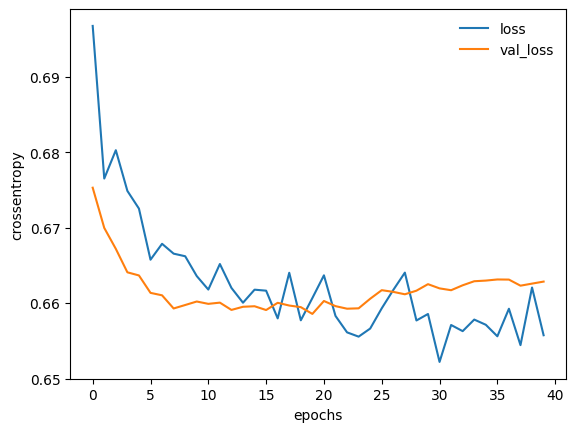

In [356]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")

In [366]:
Y_pred = model.predict(X_test)
Y_pred_cls = (Y_pred > 0.5).astype("int32")
Y_pred_ = Y_pred_cls.reshape(-1)

print(classification_report(Y_test, Y_pred_))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

         0.0       0.59      0.87      0.70       436
         1.0       0.55      0.21      0.30       338

    accuracy                           0.58       774
   macro avg       0.57      0.54      0.50       774
weighted avg       0.57      0.58      0.53       774

